### Configuration Variables

In [143]:
currentSeason = "2016-17"   # The current academic year. Can replace with python datettime

## Scrape Harvard Bio Data

In [4]:
# Assumes Anaconda Distribution

# For data manipulation
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
PROJ_ROOT = os.pardir

# For Scraping
from bs4 import BeautifulSoup
import requests
import time

# For munging
import re
import json

# Backoff time for large scrapes
THROTTLE_TIME = .05

# ipython magics
%load_ext watermark
%matplotlib inline
# a nice bonus for making progress bars in ipython
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
tqdm.pandas()

In [5]:
%watermark -a "Cameron Yick" -d -t -v -p pandas,seaborn,matplotlib,bs4 -g

Cameron Yick 2016-11-22 16:13:23 

CPython 2.7.12
IPython 5.1.0

pandas 0.18.1
seaborn 0.7.1
matplotlib 1.5.3
bs4 4.5.1
Git hash: 4292a278244738cdafcf5b2665e214ac4d78b216


In [8]:
root_url = "http://www.gocrimson.com"

In [30]:
# site root is not the same things as the home landing page 
homepage_url = "http://www.gocrimson.com/landing/index"

In [9]:
# Core functions related to data scraping
# Kept here for readability, eventually move to 'src' folder

def getBodySoup(link):
    'Given URL Returns BS4 Object for link, feat. HTML body'
#     print("."),
    time.sleep(THROTTLE_TIME)
    site_url = link
    result = requests.get(site_url)
    if result.status_code is 200:
        return BeautifulSoup(result.content, 'lxml').find('body')
    else:
        print "Site is down!"
        return None

In [65]:
# Get list of all harvard sports (different layout from yale)
def getSportLinks(soup):
    
    # Submenus for sports: 0 men, 1 women
    gender_menus = soup.select("#submenu1")[0]\
                .find("ul", class_="clearfix")\
                .find_all("li", recursive=False)
            
    sports = []
    for gender in gender_menus:
        sportrows = gender.find_all('a', {'data-title': "Roster"})
        for s in sportrows:
            sports.append(s['href'])
            
    # Select all the roster urls
    return sports
            

## Get Each Sports Page from Homepage

In [66]:
# Verify that we get all the sports
homeSoup = getBodySoup(homepage_url)


In [69]:
sports = getSportLinks(homeSoup)

In [61]:
# Every other sport has male and female versions


In [60]:
# upon inspection- there are several multi-gender sports
# There are an equal number of sports offered to men and women, unlike at Yale

# (xc) (male and female listings)
# (sailing) (male and female listings)
# (track) (male and female listings)
# (skiing) ski team (does not separate by gender)

# There are also several gender exclusive sports
# bsb (baseball) for men, softball for women
# wrestling for men, field hockey for women
# football for men, rugby for women

# The rosters that list both genders will need to be processed slightly differently.

In [70]:
print sports

['/sports/bsb/2016-17/roster', '/sports/mbkb/2016-17/roster', '/sports/mcrew-hw/2016-17/roster', '/sports/mcrew-lw/2016-17/roster', '/sports/xc/2016-17/roster', '/sports/mfencing/2016-17/roster', '/sports/fball/2016-17/roster', '/sports/mgolf/2016-17/roster', '/sports/mice/2016-17/roster', '/sports/mlax/2016-17/roster', '/sports/sailing/2016-17/roster', '/sports/skiing/2016-17/roster', '/sports/msoc/2016-17/roster', '/sports/msquash/2016-17/roster', '/sports/mswimdive/2016-17/roster', '/sports/mten/2016-17/roster', '/sports/track/2016-17/roster-include', '/sports/mvball/2016-17/roster', '/sports/mwaterpolo/2016-17/roster', '/sports/wrest/2016-17/roster', '/sports/wbkb/2016-17/roster', '/sports/wcrew-hw/2016-17/roster', '/sports/wcrew-lw/2016-17/roster', '/sports/xc/2016-17/roster', '/sports/wfencing/2016-17/roster', '/sports/fh/2016-17/roster', '/sports/wgolf/2016-17/roster', '/sports/wice/2016-17/roster', '/sports/wlax/2016-17/roster', '/sports/wrugby/2016-17/roster', '/sports/sailing

In [74]:
# Let's make a proper data structure
df = pd.DataFrame(sports)
df.columns = ['href']

In [75]:
df.head()

,href
0,/sports/bsb/2016-17/roster
1,/sports/mbkb/2016-17/roster
2,/sports/mcrew-hw/2016-17/roster
3,/sports/mcrew-lw/2016-17/roster
4,/sports/xc/2016-17/roster


In [94]:
# pull the index term off the homepage
getSportCode = re.compile('sports/([a-z\-]*)/')
df['sportCode'] = df['href'].apply(lambda x: getSportCode.search(x).group(1))

In [96]:
df.head(20)

,href,sportCode
0,/sports/bsb/2016-17/roster,bsb
1,/sports/mbkb/2016-17/roster,mbkb
2,/sports/mcrew-hw/2016-17/roster,mcrew-hw
3,/sports/mcrew-lw/2016-17/roster,mcrew-lw
4,/sports/xc/2016-17/roster,xc
5,/sports/mfencing/2016-17/roster,mfencing
6,/sports/fball/2016-17/roster,fball
7,/sports/mgolf/2016-17/roster,mgolf
8,/sports/mice/2016-17/roster,mice
9,/sports/mlax/2016-17/roster,mlax


In [98]:
# Confirm there are 4 sports with 2 genders
bothGenders = df[df['href'].duplicated()]
bothGenders

,href,sportCode
23,/sports/xc/2016-17/roster,xc
30,/sports/sailing/2016-17/roster,sailing
31,/sports/skiing/2016-17/roster,skiing
37,/sports/track/2016-17/roster-include,track


In [99]:
cleaned = df[df['href'].duplicated() == False]

In [100]:
# visit 36 pages for years of rosters!
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 39
Data columns (total 2 columns):
href         36 non-null object
sportCode    36 non-null object
dtypes: object(2)
memory usage: 864.0+ bytes


In [101]:
df.head()


,href,sportCode
0,/sports/bsb/2016-17/roster,bsb
1,/sports/mbkb/2016-17/roster,mbkb
2,/sports/mcrew-hw/2016-17/roster,mcrew-hw
3,/sports/mcrew-lw/2016-17/roster,mcrew-lw
4,/sports/xc/2016-17/roster,xc


The gender extraction code from the yale scrape doesn't hold due to the ski team issues noticed above, recommend deciding whether gender is a useful thing to keep track of at the sport or player lavel.


In [139]:
# Extract the genders for each sport: m / f / coed
# getGender = re.compile("\/sports\/([mcw])-")
# def getSportGender(url):
#     return getGender.search(url).group(1)

In [140]:
# sports['gender'] = sports['href'].map(getSportGender)

In [ ]:
# Sanity check on # of genders per sport- . Only 1 coed sport shares a webpage
# One could give the other coed sports (Swim, track, basketball) coed designation, although
# having both genders on 1 team is unique to sailing.
# sports.groupby('gender').count()

## Get the Seasons for which we have data for each sport

Below is some scratch code while the main functions are tested.

Unlike with yale, it looks like every sport's roster is lready up to date.

In [108]:
def sportIndexURL(code):
    "given a team code, return url to page for that team"
    return root_url + "/sports/" + code + "/index"

In [109]:
test = sportIndexURL(df['sportCode'].iloc[1])

In [115]:
print test

http://www.gocrimson.com/sports/mbkb/index


In [110]:
teamsoup = getBodySoup(test)

In [142]:
getSeason = re.compile("([\d\-]*)\/roster")
hasRoster = re.compile('Roster')
def getCurrentSeason(team_code):
    team_url = sportIndexURL(team_code)
    teamsoup = getBodySoup(team_url)
    link = teamsoup.find('a', text=hasRoster)
    return getSeason.search(link['href']).group(1) 

In [117]:
# Check what the most current roster listing for the sport is.
cleaned['currentRoster'] = cleaned['sportCode'].progress_apply(lambda x: getCurrentSeason(x))




  0%|                                                                       | 0/36 [00:00<?, ?it/s]


  6%|███▌                                                           | 2/36 [00:02<00:48,  1.43s/it]


  8%|█████▎                                                         | 3/36 [00:06<01:06,  2.01s/it]


 11%|███████                                                        | 4/36 [00:08<01:10,  2.20s/it]


 14%|████████▊                                                      | 5/36 [00:11<01:15,  2.43s/it]


 17%|██████████▌                                                    | 6/36 [00:14<01:11,  2.37s/it]


 19%|████████████▎                                                  | 7/36 [00:16<01:05,  2.26s/it]


 22%|██████████████                                                 | 8/36 [00:19<01:10,  2.50s/it]


 25%|███████████████▊                                               | 9/36 [00:20<01:02,  2.30s/it]


 28%|█████████████████▏                                            | 10/36 [00:

In [118]:
# Check what the current roster looks like!
cleaned.head(8)

,href,sportCode,currentRoster
0,/sports/bsb/2016-17/roster,bsb,2016-17
1,/sports/mbkb/2016-17/roster,mbkb,2016-17
2,/sports/mcrew-hw/2016-17/roster,mcrew-hw,2016-17
3,/sports/mcrew-lw/2016-17/roster,mcrew-lw,2016-17
4,/sports/xc/2016-17/roster,xc,2016-17
5,/sports/mfencing/2016-17/roster,mfencing,2016-17
6,/sports/fball/2016-17/roster,fball,2016-17
7,/sports/mgolf/2016-17/roster,mgolf,2016-17


In [120]:
# Every roster is up to date!
cleaned['currentRoster'].value_counts()

2016-17    36
Name: currentRoster, dtype: int64

## Getting Rosters from Every Season


In [127]:
def prevSeason(season):
    'Given a season, return the previous one.'
    '2015-16 becomes 2014-15'
    years = season.split("-")
    prevYear = int(years[0]) - 1
    return "{0}-{1}".format(prevYear, years[0][2:])


def getSeasons(team_url, current_season):
    'given current season, check how many seasons back of rosters we can collect.'
    ' If refactoring, might as well save the rosters too.'

    print("\nDownload " + team_url)
    hasRoster = 1
    season = current_season
    seasons = {}

    while (hasRoster):
        print(season[-2:]),
        season_url = root_url + "/sports/{0}/{1}/roster".format(team_url, season)
        tsoup = getBodySoup(season_url)
        if not tsoup:
            break
        table = tsoup.find('table')
        if not table:
            break
        rows = table.find_all('tr')
        if not rows:
            break
        # different pages handled errors differently. ex:
    
        # invoke the no 1-person team rule- if the roster table only has 2 or fewer rows in it, it's probably not 
        #         ok.
        if len(rows) < 3:
            break
        else:
            # Getting the rosters!
            people = []
            for row in rows:
                person = []
                for cell in row.find_all('td'):
                    bio_link = cell.find('a')
                    cellText = cell.text.strip()
                    
                    if bio_link:
                        
                        nameCard = {
                            'name': cellText,
                            'link': bio_link['href']
                        }
                        
                        person.append(nameCard)
                    else:
                        person.append(cellText)
                people.append(person)
                
            seasons[season] = people
            season = prevSeason(season)
            
        
    return seasons
        

In [124]:
cleaned.shape

(36, 3)

#### Note handle the WWII rosters as a special case
Basketball for some reason goes all the way back... we have to skip the WWII years if we were being thorough. Given that those athletes lack bios, we'll omit them for now but could revisit them in a future project.

Harvard men's soccer data quality is also surprisingly deficient, they only have 2 years of rosters to work with.

In [129]:
%%time
# Download the rosters for each sport
# Parallelize another time, split into separate variable due to some odd memory bug.
rosters = cleaned[['sportCode', 'currentRoster']].apply(lambda x: getSeasons(x['sportCode'], x['currentRoster']), axis='columns')

 
Download bsb
17 16 15 14 13 12 11 10 09 08 
Download mbkb
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 02 01 00 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 Site is down!

Download mcrew-hw
17 16 15 14 13 12 11 10 09 08 
Download mcrew-lw
17 16 15 14 13 12 11 10 09 08 
Download xc
17 16 15 14 13 12 11 10 09 08 
Download mfencing
17 16 15 14 13 12 11 10 09 08 
Download fball
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 02 01 00 Site is down!

Download mgolf
17 16 15 14 13 12 11 10 09 08 
Download mice
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 02 
Download mlax
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 
Download sailing
17 16 15 14 13 12 11 10 09 08 
Download skiing
17 16 15 14 13 12 
Download msoc
17 16 
Download msquash
17 16 15 14 13 12 11 10 09 08 
Download mswimdive
17 16 15 14 13 12 11 10 09 08 
Download mten
17 16 15 14 13 12 11 10 09 08 07 
Download t

In [149]:
len(rosters)

36

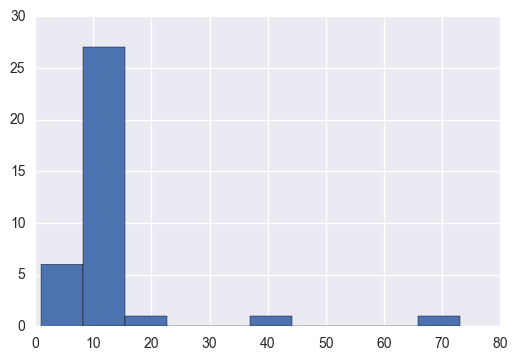

In [130]:
# Everybody has at least 6 years of data. There are a few sports with 14 years of data. 
# I wonder what made a team join?
# We can do facet plots of how the size of a team's roster changed from year to year.
# Alternately, we can build a list of what high schools people come from...
rosters.map(len).hist()

In [155]:
type(rosters)

pandas.core.series.Series

In [158]:
dRosters = pd.DataFrame(rosters)

In [159]:
dRosters.head()

,0
0,{u'2008-09': [[{'link': '/sports/bsb/2008-09/r...
1,{u'1989-90': [[{'link': '/sports/mbkb/1989-90/...
2,{u'2008-09': [[{'link': '/sports/mcrew-hw/2008...
3,{u'2008-09': [[{'link': '/sports/mcrew-lw/2008...
4,{u'2008-09': [[{'link': '/sports/xc/2008-09/ro...


In [161]:
export = dRosters.join(df)

In [164]:
export.columns

Index([0, u'href', u'sportCode', u'nSeasons', u'rosters'], dtype='object')

In [167]:
select = export[['rosters', 'sportCode', 'nSeasons']]

In [166]:
export.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 39
Data columns (total 5 columns):
0            36 non-null object
href         36 non-null object
sportCode    36 non-null object
nSeasons     36 non-null float64
rosters      36 non-null object
dtypes: float64(1), object(4)
memory usage: 1.7+ KB


In [140]:
# check what the number of people in a season looks like
# Verify it downloaded correctly
# df.iloc[0]['rosters']['2010-11']

In [170]:
select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 39
Data columns (total 3 columns):
rosters      36 non-null object
sportCode    36 non-null object
nSeasons     36 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.1+ KB


In [168]:
# dump as pickle too so objects don't get turned into strings
EXPORT_PICKLE = os.path.join(PROJ_ROOT, "data", "raw", "harvard_sports.p")
select.to_pickle(EXPORT_PICKLE)

In [169]:
# Dump the file!
EXPORT_PATH = os.path.join(PROJ_ROOT, "data", "raw", "harvard_sports.json")
select.to_json(EXPORT_PATH)